In [1]:
def binary_to_decimal(binary_list):
    decimal_list = []
    for binary_num in binary_list:
        decimal_num = int(binary_num, 2)
        decimal_list.append(decimal_num)
    return decimal_list

def remove_repeated_elements(input_list):
    repeated = []
    for element in input_list:
        if input_list.count(element) > 1 and element not in repeated:
            repeated.append(element)
    return [x for x in input_list if x not in repeated]

def decimal_to_binary(decimal_list):
    binary_list = []
    for decimal in decimal_list:
        binary = bin(decimal)
        binary = binary[2:] # remove the '0b' prefix
        binary_list.append(binary)
    return binary_list

def apply_x_error_correction(conditions, circuit):
    for condition, qubit in conditions.items():
        circuit.x(qubit).c_if(c, condition)
        
def apply_z_error_correction(conditions, circuit):
    for condition, qubit in conditions.items():
        circuit.z(qubit).c_if(c, condition)
       

## 17 Qubit Surface Code

Creating a gate to allow us to initialize. With all qubits in |0>, one surface code cycle initializes the logical |0> state.

In [2]:
from math import *
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

sc = QuantumCircuit(17)
round1 = [0,2,4,5,6,7,9,10,11,12,14,16]
round2_m = [1,3,8,13,15]
round2_p = [2,7,9,14]
round3_m = [2,7,9,14]
round3_p = [1,3,8,13,15]
final_rot = [0,2,4,5,6,7,9,10,11,12,14,16]
meas_qubits = [0,4,5,6,10,11,12,16]

#Create the first rotations
for i in range(0,17):
    if i in round1:
        sc.ry(-pi/2,i)

#Firstround of  cz gates
sc.cz(1,4)
sc.cz(2,5)
sc.cz(3,6)
sc.cz(8,10)
sc.cz(9,11)
sc.cz(14,16)


#Second rotations
for i in range(0,17):
    if i in round2_m:
        sc.ry(-pi/2,i)
    if i in round2_p:
        sc.ry(pi/2,i)

#Second round of cz gates
sc.cz(1,5)
sc.cz(4,7)
sc.cz(6,9)
sc.cz(8,11)
sc.cz(10,14)
sc.cz(13,16)


#Third round of cz gates
sc.cz(0,3)
sc.cz(2,6)
sc.cz(5,8)
sc.cz(7,10)
sc.cz(9,12)
sc.cz(11,15)


#Third rotations
for i in range(0,17):
    if i in round3_m:
        sc.ry(-pi/2,i)
    if i in round3_p:
        sc.ry(pi/2,i)


#Fourth round of cz gates
sc.cz(0,2)
sc.cz(5,7)
sc.cz(6,8)
sc.cz(10,13)
sc.cz(11,14)
sc.cz(12,15)


#Final rotations
for i in range(0,17):
    if i in final_rot:
        sc.ry(pi/2,i)


my_gate = sc.to_gate() #create gate from surface code

from qiskit_aer.noise import pauli_error
meas_qubits = [0,4,5,6,10,11,12,16]
data_qubits = [1, 2, 3, 7, 8, 9, 13, 14, 15]
c1 = ClassicalRegister(8)
q1 = QuantumRegister(17)
new_circ = QuantumCircuit(q1,c1)
new_circ.append(my_gate,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
                

new_circ.x(1)
new_circ.z(1)
# Create a dict of conditions of single x errors for c_if statements


new_circ.append(my_gate,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
for i in range(0,8):
    new_circ.measure(meas_qubits[i],c1[i])

# new_circ.draw('mpl')

In [ ]:
# Create a classical register with 9 bits
cr = ClassicalRegister(9)

# Add the classical register to the quantum circuit
new_circ.add_register(cr)

for i in range(0,9):
    new_circ.measure(data_qubits[i],cr[i])


simulator = Aer.get_backend('qasm_simulator')
# Execute the circuit on the simulator
result = execute(new_circ, simulator, shots = 100).result()

# Get the counts from the result
counts = result.get_counts()

print(counts)

# Noise Model

Logical0 initial state
Runtime: 2278.3 seconds


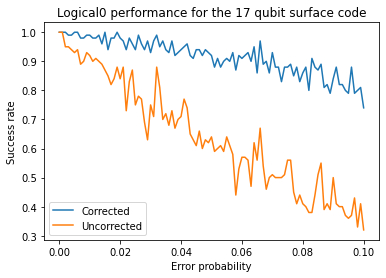

In [4]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit_aer.noise import pauli_error
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Hard-coded constants
random.seed(42)     # For reproducibility
Nshots = 100

q = QuantumRegister(17)              # Create 18-qubit quantum register
c = ClassicalRegister(8)            # Create 8-bit classical register
cr = ClassicalRegister(9)           # Create 9-bit classical register to measure the data qubits
simulator = Aer.get_backend('qasm_simulator')   # Choose simulator


meas_qubits = [0,4,5,6,10,11,12,16] # Create a list of ancilla qubits
data_qubits = [1, 2, 3, 7, 8, 9, 13, 14, 15] # Create a list of data qubits

#Create dictionaries to correct for z and x errors, key is error syndrome, value is erronus qubit
#Currently accounts for up to 3 Pauli X and/or Z errors.
x_cond = {23: 7, 29: 8, 77: 9, 69: 15, 19: 7, 25: 8, 73: 9, 65: 15, 108: 9, 100: 15, 192: 15, 224: 15, 7: 1, 3: 1,
          38: 1, 130: 1, 162: 1, 54: 7, 146: 7, 178: 7, 152: 8, 184: 8, 200: 9, 232: 9, 176: 13, 60: 8,2:1, 8:2, 8:3,
          18:7, 24:8, 72:9, 16:13 , 16:14, 64:15, 6:1, 13:2, 9:3,22:7,60:8,104:9, 144:13,96:14,176:15, 14 :4, 14: 5, 94: 4, 94: 6 , 86: 4, 86: 9, 95: 4, 95: 6, 87:4, 87:9, 91:4, 91:6, 83:4, 83:9 ,
           44:6, 44:9, 79: 1, 79:6, 71:1, 71:9, 75:1, 75:6, 67: 1, 67:9, 30: 1, 30: 5, 78: 1, 78: 6, 70:1, 70: 9, 110:1, 
          110:6, 102:1, 102:9,98: 1, 98: 1, 194:1, 194: 9, 226:1, 226:9, 126:4, 126: 9, 118: 4, 118: 9, 114: 4, 114: 9,
          210: 4, 210: 9, 242: 4, 242: 9, 120: 5, 120:9, 52:1, 52:4, 202: 1, 202: 1, 234:1, 234:6, 106:1, 106:6, 
          218:4, 218:6, 250:4, 250:6, 122:5,122:6, 112:5, 112:6, 135 : 1, 167 : 1, 131: 1 , 163 : 1, 45: 2, 137 :2,
          169: 2, 56:5, 141 :3, 173 :3, 151 : 4, 183 : 4, 157 : 5, 189: 5, 205 : 6, 237 : 6, 181 : 7 , 147: 4, 179 : 4, 
          153 : 5, 185 : 5,  201 : 6, 233 : 6, 177 : 7, 148: 7, 28: 5, 149 : 8, 197: 9, 229: 9, 145: 8, 193: 9, 225:9,
          180:8}
z_cond = {23: 2, 29: 2, 77: 2, 69: 2, 19: 3, 25: 3, 73: 3, 65: 3, 108: 8, 100: 8, 192: 13, 224: 14, 7: 2, 3: 3, 38: 8,
          130: 13, 162: 14, 54: 8, 146: 13, 178: 14, 152: 13, 184: 14, 200: 13, 232: 14, 176: 14, 60: 8, 4:1, 5:2, 1:3,
          4:7, 36:8, 32:9, 128:13, 160:14, 32:15, 6:1, 13:2, 9:3,22:7,60:8,104:9, 144:13,96:14,176:15, 14:1, 94:1, 86:1, 95:2, 87:2, 91:3, 83:3, 44:5, 79:2, 71:2, 75:3, 67:3, 30:4, 78:4, 70:4, 110:5, 102:5, 98:6,
           194:7, 226:8, 126:5, 118:5, 114:6, 210:7, 242:8, 120:6, 52:5, 202:7, 234:8, 106:9, 218:7, 250:8, 122:9, 112:9,
          135:2, 135: 7, 167:2, 167:8, 131:3, 131:7, 163:3, 163:8, 45:3, 45: 5, 137:3, 137:7, 169:3, 169:8,
           56:7, 56:8, 141:2, 141:7, 173:2, 173:8 , 151:2, 151:7, 183:2, 183:8, 157:2, 157:7, 189:2, 189:8,
           205:2, 205:7 ,237:2, 237:8, 181:2, 181:8, 147:3, 147:7, 179:3, 179:8, 153:3, 153:7, 185 :3, 185:8,
           201:3, 201:7, 233:3, 233:8, 177:3, 177:8, 148:5, 148:8, 28:3, 28:5, 149:7, 149:8, 197:7,
           197:7, 229:8, 229:9, 145:7, 145:8, 193:7, 193:9, 225:8, 225:9, 180:7, 180:9}
    
error_probs = np.arange(0, 0.101, 0.001)
sc_gate = sc.to_gate() #create gate from surface code
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Subroutine to loop over pauli_error probabilities
# Argument 'init' for |0>
def scan_probs(init):
    success_rates = []
    uncorr_rates = []
    for p_err in error_probs:
        sc = QuantumCircuit(q, c)  # Create quantum circuit
        
        #Initialize logical 0 
        sc.append(sc_gate, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]) 

        # Construct a 1-qubit bit-flip error
        error = pauli_error([('X', 0.5 * p_err),
                             ('Z', 0.5 * p_err),
                             ('I', 1.0 - p_err)])

        # Combine the circuit and the error channel
        for n in range(17):
            if n in data_qubits:
                sc.append(error, [n])
    
        #Append our 17 qubit surface code entangling gate
        sc.append(sc_gate, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
        
        
        # Measure the eight ancilla qubits
        for j in range(0,8):
            sc.measure(meas_qubits[j],j)
        
        #Correct for single phase flip and bit flip errors
        apply_x_error_correction(x_cond,sc)
        apply_z_error_correction(z_cond,sc)
        
        sc.x(1).c_if(c,74)
        sc.x(6).c_if(c,74)
        sc.x(1).c_if(c,66)
        sc.x(9).c_if(c,66)
        sc.x(4).c_if(c,90)
        sc.x(6).c_if(c,90)
        sc.x(4).c_if(c,82)
        sc.x(9).c_if(c,82)
        
        sc.z(2).c_if(c,133)
        sc.z(7).c_if(c,133)
        sc.z(2).c_if(c,165)
        sc.z(8).c_if(c,165)
        sc.z(3).c_if(c,129)
        sc.z(7).c_if(c,129)
        sc.z(3).c_if(c,161)
        sc.z(8).c_if(c,161)
        # Add the classical register to the quantum circuit
        
        sc.add_register(cr)
        # Check the state of the data qubits
        for k in range(0,9):
            sc.measure(data_qubits[k],cr[k])
        
        # Reproducibly execute the circuit on the simulator
        seed = random.randrange(0, int(1e6))
        result = execute(sc, simulator, shots=Nshots,
                         seed_simulator=seed).result()
        # Get the counts from the result
        counts = result.get_counts()
        
        
        num_success = 0
        raw_success = 0
        counts_dict = dict(counts)
        for key, value in counts_dict.items():
            if key[:9] == '000000000':
                num_success += value
                if key == '000000000 00000000':     # Correct without correction
                    raw_success += value
        success_rates.append(num_success / float(Nshots))
        uncorr_rates.append(raw_success / float(Nshots))
        #print("%.3g %.3g %.3g" % (p_err, success_rates[-1], uncorr_rates[-1]))

    return success_rates, uncorr_rates
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Main code
# Loop over |0> and |+> initial states- without |+> currently
for state in ['zero']:
    runtime = -time.time()
    if state == 'zero':
        print("Logical0 initial state")
    else:
        # Blank line in output to separate results
        print("\nLogical+ initial state")

    success_rates, uncorr_rates = scan_probs(state)

    # Print runtime here to ignore time spent looking at plot
    runtime += time.time()
    print("Runtime: %0.1f seconds" % runtime)

    if state == 'zero':
      title = 'Logical0 performance for the 17 qubit surface code'
    else:
      title = 'Logical+ performance for the 17 qubit surface code'

    # Plot the success rate as a function of the error probability
    # TODO: ADD UNCORRECTED VS CORRECTED...
    plt.plot(error_probs, success_rates, label='Corrected')
    plt.plot(error_probs, uncorr_rates, label='Uncorrected')
    plt.title(title)
    plt.xlabel('Error probability')
    plt.ylabel('Success rate')
    plt.legend(loc='lower left')
    plt.show()

The code uses the Qiskit library to simulate the error correction of a 17-qubit quantum computer using the surface code. The noise model used is the Pauli error noise model. It does this by applying a series of errors to the system and measuring the success rate of error correction. The code loops over different error probabilities, applying each one to the system, running the simulation, and measuring the success rate. The code then plots the success rate as a function of the error probability and computes the runtime of the simulation. Currently with runtime issues.

The cell below illustrates all the error syndromes for all x errors on seperate qubits, which are then used to create the binary lists below.

In [ ]:
for i in range(8):
    for j in range(i + 1, 9):
        new_circ = QuantumCircuit(17, 8)
        new_circ.append(my_gate, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
        new_circ.z(data_qubits[i])
        new_circ.x(data_qubits[j])
        new_circ.append(my_gate, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
        for k in range(8):
            new_circ.measure(meas_qubits[k], k)
        # Create a classical register with 9 bits
        cr = ClassicalRegister(9)

        # Add the classical register to the quantum circuit
        new_circ.add_register(cr)

        # Measure data qubits
        for l in range(9):
            new_circ.measure(data_qubits[l], cr[l])

        simulator = Aer.get_backend('qasm_simulator')
        # Execute the circuit on the simulator
        result = execute(new_circ, simulator, shots=1).result()

        # Get the counts from the result
        counts = result.get_counts()

        print(f'Phase flip on data qubit {i + 1} and bit flip on {j+1}', counts)


The cell below uses the binary_to_decimal and remove_repeated_elements functions to get a list of unique error syndromes for two x errors, two z erros and a z and x error in decimal notation.

In [ ]:
x_x_bin_list = ['00001010',    '00001010',    '00010000',    '00011010',    '01001010',    '00010010',    '00010010',    
                '01000010',    '00000000',    '00011010',    '00010000',    '01000000',    '00011000',    '00011000', 
                '01001000',    '00011010',    '00010000',    '01000000',    '00011000',    '00011000',    '01001000',   
                '00001010',    '01011010',    '00000010',    '00000010',    '01010010',    '01010000',    '00001000',  
                '00001000',    '01011000',    '01011000',    '01011000',    '00001000',    '00000000',    '01010000',  
                '01010000']
z_z_bin_list = ['00000001', '00000101', '00000000', '00100000', '00100100', '10000100', '10100100', 
                '00100100', '00000100', '00000001', '00100001', '00100101', '10000101', '10100101', '00100101', 
                '00000101', '00100101', '00100001', '10000001', '10100001', '00100001', '00100000', '00100100', 
                '10000100', '10100100', '00100100', '00000100', '10100100', '10000100', '00000100', '10100000', 
                '10000000', '00000000', '00100000', '10100000', '10000000']

x_z_bin_list = [ "00001100",   "00001100",    "00010110",    "00011100",    "01001100",    "00010100",    "00010100",    
                "01000100",    "00001101",    "00010111",    "00011101",    "01001101",    "00010101",    "00010101",  
                "01000101",    "00010011",    "00011001",    "01001001",    "00010001",    "00010001",    "01000001", 
                "00011100",    "01001100",    "00010100",    "00010100",    "01000100",    "01101100",    "00110100", 
                "00110100",    "01100100",    "00110000",    "00110000",    "01100000",    "10010000",    "11000000", 
                "11100000",'00000111',  '00000011',  '00000110',  '00100110',  '00100010',  '10000010',  '10100010',  
                '00100010', '00001001',  '00001100',  '00101100',  '00101000',  '10001000',  '10101000',  '00101000', 
                '00001100', '00101100',  '00101000',  '10001000',  '10101000',  '00101000',  '00110110',  '00110010',  
                '10010010', '10110010',  '00110010',  '00111000',  '10011000',  '10111000',  '00111000',  '11001000',  
                '11101000',  '01101000',  '10110000',  '00110000',  '00110000', '00000110', '00001101', '00001001', 
                '00010110', '00111100', '01101000', '10010000', '01100000', '10110000']






x_x_conditions = remove_repeated_elements(binary_to_decimal(x_x_bin_list))

z_z_conditions = remove_repeated_elements(binary_to_decimal(z_z_bin_list))

x_z_conditions = remove_repeated_elements(binary_to_decimal(x_z_bin_list))

#ToDo x_x and z_z
print(x_z_conditions)


The code below introduces x_cond and z_cond, two dictionaries containing the error syndromes (in decimal notation) as keys and the erronus qubit as the values. These dictionaries currently account for at most 2 phase and bit flip errors, with the syndromes unique.
It also contains dictionaries for unique error syndromes for 3 phase and bit flip errors.

In [ ]:
x_x_conditions = [74, 66, 90, 82]
z_z_conditions = [133, 165, 129, 161]
x_z_conditions = [23, 29, 77, 69, 19, 25, 73, 65, 108, 100, 192, 224, 7, 3, 38, 130, 162, 54, 
           146, 178, 152, 184, 200, 232, 176, 60]
x_conditions = [2, 8, 8, 18, 24, 72, 16, 16, 64] # Create a list of conditions of single x errors for c_if statements
z_conditions = [4, 5, 1, 4, 36, 32, 128, 160, 32]  # Create a list of conditions of single z errors for c_if statements
single_x_z_conditions = [6, 13, 9, 22, 60, 104, 144,96, 176] # Create a list of conditions for x and z errors on single qubits

x_cond = {23: 7, 29: 8, 77: 9, 69: 15, 19: 7, 25: 8, 73: 9, 65: 15, 108: 9, 100: 15, 192: 15, 224: 15, 7: 1, 3: 1,
          38: 1, 130: 1, 162: 1, 54: 7, 146: 7, 178: 7, 152: 8, 184: 8, 200: 9, 232: 9, 176: 13, 60: 8,2:1, 8:2, 8:3,
          18:7, 24:8, 72:9, 16:13 , 16:14, 64:15, 6:1, 13:2, 9:3,22:7,60:8,104:9, 144:13,96:14,176:15} #For up to 2 err
z_cond = {23: 2, 29: 2, 77: 2, 69: 2, 19: 3, 25: 3, 73: 3, 65: 3, 108: 8, 100: 8, 192: 13, 224: 14, 7: 2, 3: 3, 38: 8,
          130: 13, 162: 14, 54: 8, 146: 13, 178: 14, 152: 13, 184: 14, 200: 13, 232: 14, 176: 14, 60: 8, 4:1, 5:2, 1:3,
          4:7, 36:8, 32:9, 128:13, 160:14, 32:15, 6:1, 13:2, 9:3,22:7,60:8,104:9, 144:13,96:14,176:15} #For up to 2 err

x_three = {14 :4, 14: 5, 94: 4, 94: 6 , 86: 4, 86: 9, 95: 4, 95: 6, 87:4, 87:9, 91:4, 91:6, 83:4, 83:9 ,
           44:6, 44:9, 79: 1, 79:6, 71:1, 71:9, 75:1, 75:6, 67: 1, 67:9, 
           30: 1, 30: 5, 78: 1, 78: 6, 70:1, 70: 9, 110:1, 110:6, 102:1, 102:9,
           98: 1, 98: 1, 194:1, 194: 9, 226:1, 226:9, 126:4, 126: 9,
           118: 4, 118: 9, 114: 4, 114: 9, 210: 4, 210: 9, 242: 4, 242: 9, 120: 5, 120:9,
           52:1, 52:4, 202: 1, 202: 1, 234:1, 234:6, 106:1, 106:6, 218:4, 218:6, 250:4, 250:6, 122:5,122:6, 112:5, 112:6,
          135 : 1, 167 : 1, 131: 1 , 163 : 1, 45: 2, 137 :2, 169: 2, 56:5, 141 :3, 173 :3, 151 : 4, 183 : 4, 157 : 5,
           189: 5, 205 : 6, 237 : 6, 181 : 7 , 147: 4, 179 : 4, 153 : 5, 185 : 5, 
           201 : 6, 233 : 6, 177 : 7, 148: 7, 28: 5, 149 : 8, 197: 9, 229: 9, 145: 8, 193: 9, 225:9, 180:8} #For 3 err
z_three = {14:1, 94:1, 86:1, 95:2, 87:2, 91:3, 83:3, 44:5, 79:2, 71:2, 75:3, 67:3, 30:4, 78:4, 70:4, 110:5, 102:5, 98:6,
           194:7, 226:8, 126:5, 118:5, 114:6, 210:7, 242:8, 120:6, 52:5, 202:7, 234:8, 106:9, 218:7, 250:8, 122:9, 112:9,
          135:2, 135: 7, 167:2, 167:8, 131:3, 131:7, 163:3, 163:8, 45:3, 45: 5, 137:3, 137:7, 169:3, 169:8,
           56:7, 56:8, 141:2, 141:7, 173:2, 173:8 , 151:2, 151:7, 183:2, 183:8, 157:2, 157:7, 189:2, 189:8,
           205:2, 205:7 ,237:2, 237:8, 181:2, 181:8, 147:3, 147:7, 179:3, 179:8, 153:3, 153:7, 185 :3, 185:8,
           201:3, 201:7, 233:3, 233:8, 177:3, 177:8, 148:5, 148:8, 28:3, 28:5, 149:7, 149:8, 197:7,
           197:7, 229:8, 229:9, 145:7, 145:8, 193:7, 193:9, 225:8, 225:9, 180:7, 180:9} #For 3 err

The code below simulates the 17 qubit error correction, looping over three different dictionaries containing information of error syndromes. The first loop c 

Logical0 initial state
Runtime for loop 1: 1884.5 seconds
Runtime for loop 2: 1852.3 seconds
Runtime for loop 3: 1953.6 seconds


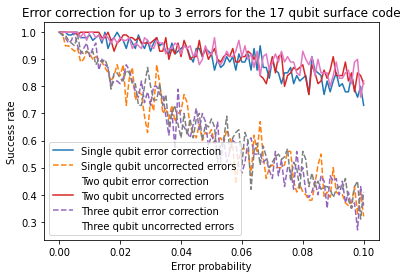

The respective fidelities are [0.9044554455445543, 0.9164356435643558, 0.9233663366336634]


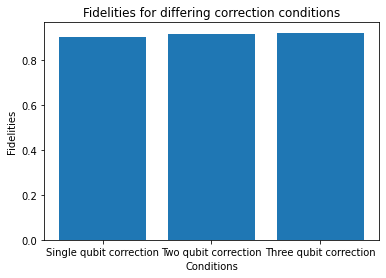

In [5]:
#Create dictionaries for single,up to two and up to three qubit errors

single_x_cond = {2:1, 8:2, 8:3, 18:7, 24:8, 72:9, 16:13 , 16:14, 64:15, 6:1, 13:2,
                 9:3,22:7,60:8,104:9, 144:13,96:14,176:15}
single_z_cond = {4:1, 5:2, 1:3, 4:7, 36:8, 32:9, 128:13, 160:14, 32:15, 6:1, 13:2,
                 9:3,22:7,60:8,104:9, 144:13,96:14,176:15}
    
double_x_cond = {23: 7, 29: 8, 77: 9, 69: 15, 19: 7, 25: 8, 73: 9, 65: 15, 108: 9, 100: 15, 192: 15, 224: 15, 7: 1, 3: 1,
          38: 1, 130: 1, 162: 1, 54: 7, 146: 7, 178: 7, 152: 8, 184: 8, 200: 9, 232: 9, 176: 13, 60: 8,2:1, 8:2, 8:3,
          18:7, 24:8, 72:9, 16:13 , 16:14, 64:15, 6:1, 13:2, 9:3,22:7,60:8,104:9, 144:13,96:14,176:15}
double_z_cond = {23: 2, 29: 2, 77: 2, 69: 2, 19: 3, 25: 3, 73: 3, 65: 3, 108: 8, 100: 8, 192: 13, 224: 14, 7: 2, 3: 3, 38: 8,
          130: 13, 162: 14, 54: 8, 146: 13, 178: 14, 152: 13, 184: 14, 200: 13, 232: 14, 176: 14, 60: 8, 4:1, 5:2, 1:3,
          4:7, 36:8, 32:9, 128:13, 160:14, 32:15, 6:1, 13:2, 9:3,22:7,60:8,104:9, 144:13,96:14,176:15}

triple_x_cond = {23: 7, 29: 8, 77: 9, 69: 15, 19: 7, 25: 8, 73: 9, 65: 15, 108: 9, 100: 15, 192: 15, 224: 15, 7: 1, 3: 1,
          38: 1, 130: 1, 162: 1, 54: 7, 146: 7, 178: 7, 152: 8, 184: 8, 200: 9, 232: 9, 176: 13, 60: 8,2:1, 8:2, 8:3,
          18:7, 24:8, 72:9, 16:13 , 16:14, 64:15, 6:1, 13:2, 9:3,22:7,60:8,104:9, 144:13,96:14,176:15, 14 :4, 14: 5, 94: 4, 94: 6 , 86: 4, 86: 9, 95: 4, 95: 6, 87:4, 87:9, 91:4, 91:6, 83:4, 83:9 ,
           44:6, 44:9, 79: 1, 79:6, 71:1, 71:9, 75:1, 75:6, 67: 1, 67:9, 30: 1, 30: 5, 78: 1, 78: 6, 70:1, 70: 9, 110:1, 
          110:6, 102:1, 102:9,98: 1, 98: 1, 194:1, 194: 9, 226:1, 226:9, 126:4, 126: 9, 118: 4, 118: 9, 114: 4, 114: 9,
          210: 4, 210: 9, 242: 4, 242: 9, 120: 5, 120:9, 52:1, 52:4, 202: 1, 202: 1, 234:1, 234:6, 106:1, 106:6, 
          218:4, 218:6, 250:4, 250:6, 122:5,122:6, 112:5, 112:6, 135 : 1, 167 : 1, 131: 1 , 163 : 1, 45: 2, 137 :2,
          169: 2, 56:5, 141 :3, 173 :3, 151 : 4, 183 : 4, 157 : 5, 189: 5, 205 : 6, 237 : 6, 181 : 7 , 147: 4, 179 : 4, 
          153 : 5, 185 : 5,  201 : 6, 233 : 6, 177 : 7, 148: 7, 28: 5, 149 : 8, 197: 9, 229: 9, 145: 8, 193: 9, 225:9,
          180:8}
triple_z_cond = {23: 2, 29: 2, 77: 2, 69: 2, 19: 3, 25: 3, 73: 3, 65: 3, 108: 8, 100: 8, 192: 13, 224: 14, 7: 2, 3: 3, 38: 8,
          130: 13, 162: 14, 54: 8, 146: 13, 178: 14, 152: 13, 184: 14, 200: 13, 232: 14, 176: 14, 60: 8, 4:1, 5:2, 1:3,
          4:7, 36:8, 32:9, 128:13, 160:14, 32:15, 6:1, 13:2, 9:3,22:7,60:8,104:9, 144:13,96:14,176:15, 14:1, 94:1, 86:1, 95:2, 87:2, 91:3, 83:3, 44:5, 79:2, 71:2, 75:3, 67:3, 30:4, 78:4, 70:4, 110:5, 102:5, 98:6,
           194:7, 226:8, 126:5, 118:5, 114:6, 210:7, 242:8, 120:6, 52:5, 202:7, 234:8, 106:9, 218:7, 250:8, 122:9, 112:9,
          135:2, 135: 7, 167:2, 167:8, 131:3, 131:7, 163:3, 163:8, 45:3, 45: 5, 137:3, 137:7, 169:3, 169:8,
           56:7, 56:8, 141:2, 141:7, 173:2, 173:8 , 151:2, 151:7, 183:2, 183:8, 157:2, 157:7, 189:2, 189:8,
           205:2, 205:7 ,237:2, 237:8, 181:2, 181:8, 147:3, 147:7, 179:3, 179:8, 153:3, 153:7, 185 :3, 185:8,
           201:3, 201:7, 233:3, 233:8, 177:3, 177:8, 148:5, 148:8, 28:3, 28:5, 149:7, 149:8, 197:7,
           197:7, 229:8, 229:9, 145:7, 145:8, 193:7, 193:9, 225:8, 225:9, 180:7, 180:9}

x_conditions_list = [single_x_cond, double_x_cond, triple_x_cond]
z_conditions_list = [single_z_cond, double_z_cond, triple_z_cond]
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit_aer.noise import pauli_error
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Hard-coded constants
random.seed(42)     # For reproducibility
Nshots = 100

q = QuantumRegister(17)              # Create 18-qubit quantum register
c = ClassicalRegister(8)            # Create 8-bit classical register
cr = ClassicalRegister(9)           # Create 9-bit classical register to measure the data qubits
simulator = Aer.get_backend('qasm_simulator')   # Choose simulator


meas_qubits = [0,4,5,6,10,11,12,16] # Create a list of ancilla qubits
data_qubits = [1, 2, 3, 7, 8, 9, 13, 14, 15] # Create a list of data qubits

#Create dictionaries to correct for z and x errors, key is error syndrome, value is erronus qubit
#Currently accounts for up to 3 Pauli X and/or Z errors.

error_probs = np.arange(0, 0.101, 0.001)
sc_gate = sc.to_gate() #create gate from surface code
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Subroutine to loop over pauli_error probabilities
# Argument 'init' for |0>
def scan_probs(init, x_cond, z_cond):
    success_rates = []
    uncorr_rates = []
    for p_err in error_probs:
        sc = QuantumCircuit(q, c)  # Create quantum circuit

        #Initialize logical 0 
        sc.append(sc_gate, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]) 

        # Construct a 1-qubit bit-flip error
        error = pauli_error([('X', 0.5 * p_err),
                             ('Z', 0.5 * p_err),
                             ('I', 1.0 - p_err)])

        # Combine the circuit and the error channel
        for n in range(17):
            if n in data_qubits:
                sc.append(error, [n])

        #Append our 17 qubit surface code entangling gate
        sc.append(sc_gate, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])


        # Measure the eight ancilla qubits
        for j in range(0,8):
            sc.measure(meas_qubits[j],j)

        #Correct for single phase flip and bit flip errors
        apply_x_error_correction(x_cond,sc)
        apply_z_error_correction(z_cond,sc)


        sc.add_register(cr)
        # Check the state of the data qubits
        for k in range(0,9):
            sc.measure(data_qubits[k],cr[k])

        # Reproducibly execute the circuit on the simulator
        seed = random.randrange(0, int(1e6))
        result = execute(sc, simulator, shots=Nshots,
                         seed_simulator=seed).result()
        # Get the counts from the result
        counts = result.get_counts()


        num_success = 0
        raw_success = 0
        counts_dict = dict(counts)
        for key, value in counts_dict.items():
            if key[:9] == '000000000':
                num_success += value
                if key == '000000000 00000000':     # Correct without correction
                    raw_success += value
        success_rates.append(num_success / float(Nshots))
        uncorr_rates.append(raw_success / float(Nshots))
        


    return success_rates, uncorr_rates
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Main code
# Create an empty list to store the labels for the legend
labels = []
fidelities = []
#Loop over the three different dictionaries
print("Logical0 initial state")
for i, (x_conditions, z_conditions) in enumerate(zip(x_conditions_list, z_conditions_list)):
    for state in ['zero']:
        runtime = -time.time()

        success_rates, uncorr_rates = scan_probs(state, x_conditions, z_conditions)
        
        #Work out the fidelity per loop and add it to the fidelities list
        fidelity = (sum(success_rates))/len(error_probs)
        fidelities.append(fidelity)
        # Print runtime here to ignore time spent looking at plot
        runtime += time.time()
        print("Runtime for loop %d: %.1f seconds" % (i+1, runtime))

        if i == 0:
            ec_type = 'Single qubit'
        elif i == 1:
            ec_type = 'Two qubit'
        elif i == 2:
            ec_type = 'Three qubit'
        else:
            raise ValueError('Too many error correction conditions')

        # Append the labels for the legend
        labels.append(ec_type + ' error correction')
        labels.append(ec_type + ' uncorrected errors')
        # Plot the success rate and uncorrected rate as a function of the error probability
        plt.plot(error_probs, success_rates, label=ec_type + ' error correction')
        plt.plot(error_probs, uncorr_rates, '--', label=ec_type + ' uncorrected errors')

    # End of loop iteration - move to the next line
    plt.plot([], [], ' ', label=' ')

plt.title('Error correction for up to 3 errors for the 17 qubit surface code')
plt.xlabel('Error probability')
plt.ylabel('Success rate')
plt.legend(labels=labels, loc='lower left')
plt.show()


print('The respective fidelities are', fidelities)
# Plot the fidelities against the conditions
conditions = ['Single qubit correction', 'Two qubit correction', 'Three qubit correction']
plt.bar(conditions, fidelities)
plt.title('Fidelities for differing correction conditions')
plt.xlabel('Conditions')
plt.ylabel('Fidelities')

# Show the plot
plt.show()


In [ ]:
#Create dictionaries for single,up to two and up to three qubit errors

single_x_cond = {2:1, 8:2, 8:3, 18:7, 24:8, 72:9, 16:13 , 16:14, 64:15, 6:1, 13:2,
                 9:3,22:7,60:8,104:9, 144:13,96:14,176:15}
single_z_cond = {4:1, 5:2, 1:3, 4:7, 36:8, 32:9, 128:13, 160:14, 32:15, 6:1, 13:2,
                 9:3,22:7,60:8,104:9, 144:13,96:14,176:15}
    
double_x_cond = {23: 7, 29: 8, 77: 9, 69: 15, 19: 7, 25: 8, 73: 9, 65: 15, 108: 9, 100: 15, 192: 15, 224: 15, 7: 1, 3: 1,
          38: 1, 130: 1, 162: 1, 54: 7, 146: 7, 178: 7, 152: 8, 184: 8, 200: 9, 232: 9, 176: 13, 60: 8}
double_z_cond = {23: 2, 29: 2, 77: 2, 69: 2, 19: 3, 25: 3, 73: 3, 65: 3, 108: 8, 100: 8, 192: 13, 224: 14, 7: 2, 3: 3, 38: 8,
          130: 13, 162: 14, 54: 8, 146: 13, 178: 14, 152: 13, 184: 14, 200: 13, 232: 14, 176: 14, 60: 8}

triple_x_cond = {14 :4, 14: 5, 94: 4, 94: 6 , 86: 4, 86: 9, 95: 4, 95: 6, 87:4, 87:9, 91:4, 91:6, 83:4, 83:9 ,
           44:6, 44:9, 79: 1, 79:6, 71:1, 71:9, 75:1, 75:6, 67: 1, 67:9, 30: 1, 30: 5, 78: 1, 78: 6, 70:1, 70: 9, 110:1, 
          110:6, 102:1, 102:9,98: 1, 98: 1, 194:1, 194: 9, 226:1, 226:9, 126:4, 126: 9, 118: 4, 118: 9, 114: 4, 114: 9,
          210: 4, 210: 9, 242: 4, 242: 9, 120: 5, 120:9, 52:1, 52:4, 202: 1, 202: 1, 234:1, 234:6, 106:1, 106:6, 
          218:4, 218:6, 250:4, 250:6, 122:5,122:6, 112:5, 112:6, 135 : 1, 167 : 1, 131: 1 , 163 : 1, 45: 2, 137 :2,
          169: 2, 56:5, 141 :3, 173 :3, 151 : 4, 183 : 4, 157 : 5, 189: 5, 205 : 6, 237 : 6, 181 : 7 , 147: 4, 179 : 4, 
          153 : 5, 185 : 5,  201 : 6, 233 : 6, 177 : 7, 148: 7, 28: 5, 149 : 8, 197: 9, 229: 9, 145: 8, 193: 9, 225:9,
          180:8}
triple_z_cond = {14:1, 94:1, 86:1, 95:2, 87:2, 91:3, 83:3, 44:5, 79:2, 71:2, 75:3, 67:3, 30:4, 78:4, 70:4, 110:5, 102:5, 98:6,
           194:7, 226:8, 126:5, 118:5, 114:6, 210:7, 242:8, 120:6, 52:5, 202:7, 234:8, 106:9, 218:7, 250:8, 122:9, 112:9,
          135:2, 135: 7, 167:2, 167:8, 131:3, 131:7, 163:3, 163:8, 45:3, 45: 5, 137:3, 137:7, 169:3, 169:8,
           56:7, 56:8, 141:2, 141:7, 173:2, 173:8 , 151:2, 151:7, 183:2, 183:8, 157:2, 157:7, 189:2, 189:8,
           205:2, 205:7 ,237:2, 237:8, 181:2, 181:8, 147:3, 147:7, 179:3, 179:8, 153:3, 153:7, 185 :3, 185:8,
           201:3, 201:7, 233:3, 233:8, 177:3, 177:8, 148:5, 148:8, 28:3, 28:5, 149:7, 149:8, 197:7,
           197:7, 229:8, 229:9, 145:7, 145:8, 193:7, 193:9, 225:8, 225:9, 180:7, 180:9}

x_conditions_list = [single_x_cond, double_x_cond, triple_x_cond]
z_conditions_list = [single_z_cond, double_z_cond, triple_z_cond]
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit_aer.noise import pauli_error
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Hard-coded constants
random.seed(42)     # For reproducibility
Nshots = 10

q = QuantumRegister(17)              # Create 18-qubit quantum register
c = ClassicalRegister(8)            # Create 8-bit classical register
cr = ClassicalRegister(9)           # Create 9-bit classical register to measure the data qubits
simulator = Aer.get_backend('qasm_simulator')   # Choose simulator


meas_qubits = [0,4,5,6,10,11,12,16] # Create a list of ancilla qubits
data_qubits = [1, 2, 3, 7, 8, 9, 13, 14, 15] # Create a list of data qubits

#Create dictionaries to correct for z and x errors, key is error syndrome, value is erronus qubit
#Currently accounts for up to 3 Pauli X and/or Z errors.

error_probs = np.arange(0, 0.101, 0.001)
sc_gate = sc.to_gate() #create gate from surface code
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Subroutine to loop over pauli_error probabilities
# Argument 'init' for |0>
def scan_probs(init, x_cond, z_cond):
    success_rates = []
    uncorr_rates = []
    for p_err in error_probs:
        sc = QuantumCircuit(q, c)  # Create quantum circuit

        #Initialize logical 0 
        sc.append(sc_gate, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]) 

        # Construct a 1-qubit bit-flip error
        error = pauli_error([('X', 0.5 * p_err),
                             ('Z', 0.5 * p_err),
                             ('I', 1.0 - p_err)])

        # Combine the circuit and the error channel
        for n in range(17):
            if n in data_qubits:
                sc.append(error, [n])

        #Append our 17 qubit surface code entangling gate
        sc.append(sc_gate, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])


        # Measure the eight ancilla qubits
        for j in range(0,8):
            sc.measure(meas_qubits[j],j)

        #Correct for single phase flip and bit flip errors
        apply_x_error_correction(x_cond,sc)
        apply_z_error_correction(z_cond,sc)


        sc.add_register(cr)
        # Check the state of the data qubits
        for k in range(0,9):
            sc.measure(data_qubits[k],cr[k])

        # Reproducibly execute the circuit on the simulator
        seed = random.randrange(0, int(1e6))
        result = execute(sc, simulator, shots=Nshots,
                         seed_simulator=seed).result()
        # Get the counts from the result
        counts = result.get_counts()


        num_success = 0
        raw_success = 0
        counts_dict = dict(counts)
        for key, value in counts_dict.items():
            if key[:9] == '000000000':
                num_success += value
                if key == '000000000 00000000':     # Correct without correction
                    raw_success += value
        success_rates.append(num_success / float(Nshots))
        uncorr_rates.append(raw_success / float(Nshots))
        


    return success_rates, uncorr_rates
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Main code
# Create an empty list to store the labels for the legend
labels = []
fidelities = []
#Loop over the three different dictionaries
print("Logical0 initial state")
for i, (x_conditions, z_conditions) in enumerate(zip(x_conditions_list, z_conditions_list)):
    for state in ['zero']:
        runtime = -time.time()

        success_rates, uncorr_rates = scan_probs(state, x_conditions, z_conditions)
        
        #Work out the fidelity per loop and add it to the fidelities list
        fidelity = (sum(success_rates))/len(error_probs)
        fidelities.append(fidelity)
        # Print runtime here to ignore time spent looking at plot
        runtime += time.time()
        print("Runtime for loop %d: %.1f seconds" % (i+1, runtime))

        if i == 0:
            ec_type = 'Single qubit'
        elif i == 1:
            ec_type = 'Two qubit'
        elif i == 2:
            ec_type = 'Three qubit'
        else:
            raise ValueError('Too many error correction conditions')

        # Append the labels for the legend
        labels.append(ec_type + ' error correction')
        labels.append(ec_type + ' uncorrected errors')
        # Plot the success rate and uncorrected rate as a function of the error probability
        plt.plot(error_probs, success_rates, label=ec_type + ' error correction')
        plt.plot(error_probs, uncorr_rates, '--', label=ec_type + ' uncorrected errors')

    # End of loop iteration - move to the next line
    plt.plot([], [], ' ', label=' ')

plt.title('Error correction for 1,2 and 3 qubit corrected errors for the 17 qubit surface code')
plt.xlabel('Error probability')
plt.ylabel('Success rate')
plt.legend(labels=labels, loc='lower left')
plt.show()


print("For single qubit correction, two qubit correction and three qubit correction, the respective fidelities are %.1f", fidelities)
# Plot the fidelities against the conditions
conditions = ['Single qubit correction', 'Two qubit correction', 'Three qubit correction']
plt.bar(conditions, fidelities)
plt.title('Fidelities for different conditions')
plt.xlabel('Conditions')
plt.ylabel('Fidelities')

# Show the plot
plt.show()



Logical0 initial state
